In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from scipy.spatial.transform import Rotation
import ipympl

%matplotlib widget

sns.set_theme()
# LaTex must be installed for this to work
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{bm}')

def drop_columns_in_df(df):
    return df.drop(columns=["header.seq", "header.stamp.secs", "header.stamp.nsecs", "header.frame_id"])

def rename_columns(df, new_colum_names: list):
    column_names = ['Time'] + new_colum_names
    
    df.columns= column_names

    return df

def normalize_df_time(df):
    start_time = df['Time'].iloc[0]

    df['Time'] -= start_time

    return df

def sync_dfs_based_on_time(dataframes: list):
    import math
    earliest_time = math.inf
    for frame in dataframes:
        if frame.iloc[0]["Time"] < earliest_time:
            earliest_time = frame.iloc[0]["Time"]

    for frame in dataframes:
        frame['Time'] -= earliest_time

    return dataframes

def df_from_pose_to_euler(df):
    quat_df = df[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
    rot = Rotation.from_quat(quat_df)
    rot_euler = rot.as_euler('xyz', degrees=True)
    euler_df = pd.DataFrame(data=rot_euler, columns=['roll', 'pitch', 'yaw'])

    conc = [df, euler_df]

    df_gt_euler = pd.concat(
        conc,
        axis=1,
        join="outer",
        ignore_index=False,
        keys=None,
        levels=None,
        names=None,
        verify_integrity=False,
        copy=True,
    )

    df_gt_euler = drop_columns_in_df(df_gt_euler)
    df_gt_euler.drop(columns=["pose.position.x", "pose.position.y", "pose.position.z", "pose.orientation.x", "pose.orientation.y","pose.orientation.z","pose.orientation.w"], inplace=True)

    return df_gt_euler

def Mask_Or_Drop_Successive_Identical_Values(df, drop=False, 
                                             keep_first=True,
                                             axis=0):

    '''
    Input:
    df should be a pandas.DataFrame of a a pandas.Series
    Output:
    df of ts with masked or dropped values
    '''
    
    # Mask keeping the first occurrence
    if keep_first:
        df = df.mask(df.shift(1) == df)
    # Mask including the first occurrence
    else:
        df = df.mask((df.shift(1) == df) | (df.shift(-1) == df))

    # Drop the values (e.g. rows are deleted)    
    if drop:
        return df.dropna(axis=axis)        
    # Only mask the values (e.g. become 'NaN')
    else:
        return df

def get_np_arr_without_nan(df_list, datacols_list, remove_identicals=True):
    np_column = np.array(["Time"] + datacols_list)
    for i in range(len(df_list)):
        if df_list[i].columns.shape == np_column.shape:
            if np.all(df_list[i].columns == np_column):
                df = df_list[i]

    if remove_identicals:
      df_with_NAN = Mask_Or_Drop_Successive_Identical_Values(df)
    else:
      df_with_NAN = df

    column_names = ['Time'] + datacols_list

    selected_rows = df_with_NAN[~df_with_NAN[datacols_list[0]].isnull()]
    reduced_df_without_NAN = selected_rows[column_names]

    return reduced_df_without_NAN.to_numpy()

def ret_track_df(df):
    # create an empty list to store DataFrames
    dfs = []

    # iterate over rows of the original DataFrame
    for index, row in df.iterrows():
        # split the bounding boxes string into individual boxes
        bbs = row['bbs'].replace('[','').replace(']','').split(', ')
        # create a DataFrame for each box and append it to the list of DataFrames
        for bb in bbs:
            bb_dict = {}
            for item in bb.split("\n"):
                key, value = item.split(": ")
                bb_dict[key.strip()] = float(value) if key.strip() not in ["id", "Class"] else value.strip().replace('"', '')
            new_row = {**row.to_dict(), **bb_dict}
            dfs.append(pd.DataFrame(new_row, index=[index]))

    # concatenate the list of DataFrames into a single DataFrame
    new_df = pd.concat(dfs, axis=0, ignore_index=True)

    new_df = new_df[["Time", "probability",	"xmin",	"ymin",	"xmax",	"ymax",	"id",	"Class"]]

    new_df['id'] = new_df['id'].astype(int)

    # extract the desired columns using loc
    new_df = new_df.loc[:, ['Time', 'id', 'probability', 'Class', 'xmin', 'ymin', 'xmax', 'ymax']]

    # calculate the center x and y coordinates
    new_df['center_x'] = (new_df['xmin'] + new_df['xmax']) / 2
    new_df['center_y'] = (new_df['ymin'] + new_df['ymax']) / 2

    # drop the original xmin, ymin, xmax, ymax columns
    new_df.drop(columns=['xmin', 'ymin', 'xmax', 'ymax'], inplace=True)

    return new_df

def remove_parentheses(string):
    return string.replace('(', '').replace(')', '')

# Define a function to extract the first three elements on the diagonal
def extract_diagonal(row):
    elements = row['pose.covariance'].split(',')
    return pd.Series([float(remove_parentheses(elements[0])), float(elements[7]), float(remove_parentheses(elements[14]))])

In [96]:
# b = bagreader('/Users/simenallum/Library/CloudStorage/OneDrive-NTNU/Project thesis - bagfiles/lab/square/no_perception/2022-11-08-11-56-31.bag')
# b = bagreader('/Users/simenallum/Library/CloudStorage/OneDrive-NTNU/Project thesis - bagfiles/lab/mission/no_perception/2022-11-08-11-19-46.bag')
b = bagreader('/home/msccomputer/catkin_ws/src/msc_thesis/test_tools/scripts/live_rosbaging/rosbags/eval_pix2geo/yaw_motion/new_TF/2023-04-19-15-12-11.bag')
b.topic_table

[INFO]  Successfully created the data folder /home/msccomputer/catkin_ws/src/msc_thesis/test_tools/scripts/live_rosbaging/rosbags/eval_pix2geo/yaw_motion/new_TF/2023-04-19-15-12-11.


,Topics,Types,Message Count,Frequency
0,/anafi/gnss_location,sensor_msgs/NavSatFix,1050,32.086660
1,/anafi/height,olympe_bridge/Float32Stamped,1050,32.119340
2,/anafi/image,sensor_msgs/Image,1057,31.817092
3,/anafi/ned_pos_from_gnss,geometry_msgs/PointStamped,1023,31.785987
4,/anafi/pose,geometry_msgs/PoseStamped,1048,32.033727
5,/anafi/rpy,geometry_msgs/Vector3Stamped,2316,99.320483
6,/qualisys/AT0/pose,geometry_msgs/PoseStamped,3487,99.367543
7,/qualisys/Anafi/pose,geometry_msgs/PoseStamped,3487,99.367543
8,/search/tracks,yolov8_ros/BoundingBoxes,1061,32.129920
9,/search/tracks/camera_coordinates_fov,pix2geo/TrackWorldCoordinate,1028,31.685255


# Compare GT vs Anafi altitude

In [45]:
anafi_height = b.message_by_topic('/anafi/height')
df_anafi_height = pd.read_csv(anafi_height)

df_anafi_height = df_anafi_height[["Time", "data"]]

df_anafi_height = rename_columns(df_anafi_height, ["height"])

df_anafi_height


,Time,height
0,1.679407e+09,2.461212
1,1.679407e+09,2.459976
2,1.679407e+09,2.461838
3,1.679407e+09,2.461670
4,1.679407e+09,2.465271
...,...,...
835,1.679407e+09,2.474503
836,1.679407e+09,2.473114
837,1.679407e+09,2.473251
838,1.679407e+09,2.472885


In [50]:
gt_anafi_height = b.message_by_topic('/qualisys/Anafi/pose')
df_gt_anafi_height = pd.read_csv(gt_anafi_height)

df_gt_anafi_height = df_gt_anafi_height[["Time", "pose.position.z"]]

df_gt_anafi_height = rename_columns(df_gt_anafi_height, ["gt_height"])

df_gt_anafi_height

,Time,gt_height
0,1.679407e+09,-2.503209
1,1.679407e+09,-2.503709
2,1.679407e+09,-2.503876
3,1.679407e+09,-2.504239
4,1.679407e+09,-2.504677
...,...,...
2801,1.679407e+09,-2.501177
2802,1.679407e+09,-2.501004
2803,1.679407e+09,-2.501022
2804,1.679407e+09,-2.501035


In [52]:
df_merged_height = sync_dfs_based_on_time([df_gt_anafi_height, df_anafi_height])

np_gt_anafi_height = get_np_arr_without_nan(df_merged_height, ["gt_height"])
np_anafi_height= get_np_arr_without_nan(df_merged_height, ["height"])


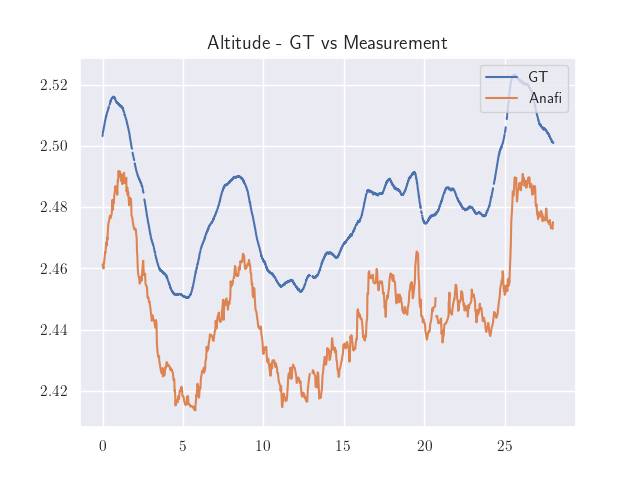

In [57]:
fig, ax = plt.subplots()

ax.plot(np_gt_anafi_height[:, 0], -np_gt_anafi_height[:, 1], label="GT")
ax.plot(np_anafi_height[:, 0], np_anafi_height[:, 1], label="Anafi")

ax.legend(loc='upper right', ncol=1)
ax.set_title('Altitude - GT vs Measurement', fontsize=14)

plt.show()


# Check Anafi position

In [18]:
gt_anafi_pos = b.message_by_topic('/qualisys/Anafi/pose')
df_gt_anafi_pos = pd.read_csv(gt_anafi_pos)

df_gt_anafi_pos = rename_columns(df_gt_anafi_pos[["Time", "pose.position.x",	"pose.position.y",	"pose.position.z"]], ["gt_x", "gt_y", "gt_z"])

df_gt_anafi_pos

,Time,gt_x,gt_y,gt_z
0,1.679407e+09,0.273977,-0.129817,-2.503067
1,1.679407e+09,0.274000,-0.129505,-2.503209
2,1.679407e+09,0.274058,-0.129702,-2.503709
3,1.679407e+09,0.274159,-0.129735,-2.503876
4,1.679407e+09,0.274108,-0.129740,-2.504239
...,...,...,...,...
2635,1.679407e+09,0.271756,-0.118360,-2.520202
2636,1.679407e+09,0.271779,-0.118444,-2.520265
2637,1.679407e+09,0.271816,-0.118869,-2.520019
2638,1.679407e+09,0.271809,-0.118799,-2.520135


In [19]:
anafi_pos_from_gnss = b.message_by_topic('/anafi/ned_pos_from_gnss')
df_anafi_pos_from_gnss = pd.read_csv(anafi_pos_from_gnss)

df_anafi_pos_from_gnss = rename_columns(df_anafi_pos_from_gnss[["Time", "point.x",	"point.y",	"point.z"]], ["x", "y", "z"])

df_anafi_pos_from_gnss

,Time,x,y,z
0,1.679407e+09,0.278225,-0.132255,-2.513702
1,1.679407e+09,0.278171,-0.132348,-2.513528
2,1.679407e+09,0.278171,-0.132348,-2.513528
3,1.679407e+09,0.278069,-0.132619,-2.513223
4,1.679407e+09,0.277915,-0.132707,-2.513130
...,...,...,...,...
756,1.679407e+09,0.271923,-0.117712,-2.520049
757,1.679407e+09,0.271923,-0.117712,-2.520049
758,1.679407e+09,0.271923,-0.117712,-2.520049
759,1.679407e+09,0.271779,-0.118290,-2.520069


In [20]:
df_merged_anafi_pos = sync_dfs_based_on_time([df_gt_anafi_pos, df_anafi_pos_from_gnss])

df_merged_anafi_pos


np_gt_anafi_pos = get_np_arr_without_nan(df_merged_anafi_pos, ["gt_x", "gt_y", "gt_z"])
np_anafi_pos_from_gnss = get_np_arr_without_nan(df_merged_anafi_pos, ["x", "y", "z"], remove_identicals=False)

np_anafi_pos_from_gnss

array([[ 1.00310993,  0.27822467, -0.13225519, -2.51370215],
       [ 1.04352975,  0.27817108, -0.13234847, -2.51352759],
       [ 1.07383156,  0.27817108, -0.13234847, -2.51352759],
       ...,
       [26.29283071,  0.27192328, -0.11771211, -2.52004883],
       [26.3237052 ,  0.27177881, -0.1182903 , -2.52006909],
       [26.36658621,  0.27177945, -0.11844389, -2.52026514]])

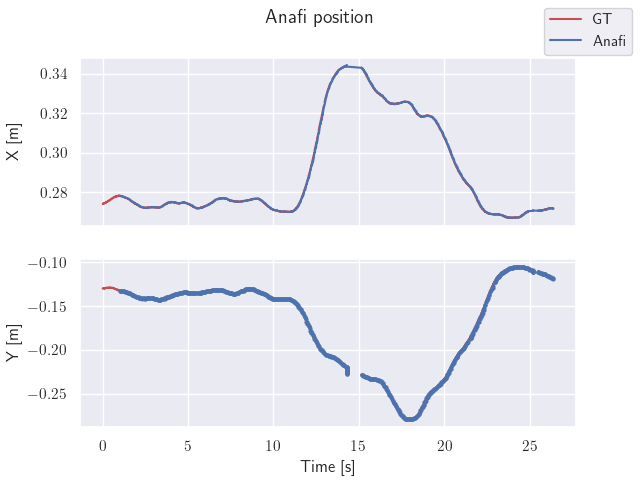

In [21]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(np_gt_anafi_pos[:,0], np_gt_anafi_pos[:,1],'-', ms=1, c='r')
axs[0].plot(np_anafi_pos_from_gnss[:,0], np_anafi_pos_from_gnss[:,1],'-', ms=1, c='b')


axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_gt_anafi_pos[:,0], np_gt_anafi_pos[:,2],'-', ms=1, c='r')
axs[1].plot(np_anafi_pos_from_gnss[:,0], np_anafi_pos_from_gnss[:,2],'o', ms=2, c='b')


axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)

handles, labels = axs[1].get_legend_handles_labels()
labels = ["GT", "Anafi"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Anafi position', fontsize=14)
fig.align_ylabels(axs)

plt.show()

# Evaluate algorithm

In [97]:
tracks_coord = b.message_by_topic('/search/tracks/world_coordinates')
df_tracks_coord = pd.read_csv(tracks_coord)

df_tracks_coord = df_tracks_coord[["Time", "x", "y", "z"]]

df_tracks_coord

,Time,x,y,z
0,1.679407e+09,0.132526,-0.039820,-0.046068
1,1.679407e+09,0.131234,-0.039065,-0.041435
2,1.679407e+09,0.131498,-0.038581,-0.041142
3,1.679407e+09,0.131707,-0.039459,-0.040726
4,1.679407e+09,0.133486,-0.038718,-0.041378
...,...,...,...,...
1023,1.679407e+09,0.135466,-0.031949,-0.057323
1024,1.679407e+09,0.135353,-0.033104,-0.056950
1025,1.679407e+09,0.134866,-0.032532,-0.058327
1026,1.679407e+09,0.135977,-0.031755,-0.058456


In [98]:
tracks_coord_fov = b.message_by_topic("/search/tracks/world_coordinates/fov")
df_tracks_coord_fov = pd.read_csv(tracks_coord_fov)

df_tracks_coord_fov = df_tracks_coord_fov[["Time", "x", "y", "z"]]

df_tracks_coord_fov  = rename_columns(df_tracks_coord_fov, ["x_f", "y_f", "z_f"])

In [99]:

gt_track_coord = b.message_by_topic('/qualisys/AT0/pose')
df_gt_track_coord = pd.read_csv(gt_track_coord)

df_gt_track_coord = rename_columns(df_gt_track_coord[["Time", "pose.position.x",	"pose.position.y",	"pose.position.z"]], ["gt_x", "gt_y", "gt_z"])

df_gt_track_coord

,Time,gt_x,gt_y,gt_z
0,1.679407e+09,0.132570,-0.001535,-0.019468
1,1.679407e+09,0.132542,-0.001556,-0.019317
2,1.679407e+09,0.132537,-0.001543,-0.019329
3,1.679407e+09,0.132569,-0.001504,-0.019316
4,1.679407e+09,0.132582,-0.001507,-0.019407
...,...,...,...,...
3482,1.679407e+09,0.132565,-0.001573,-0.019376
3483,1.679407e+09,0.132582,-0.001518,-0.019345
3484,1.679407e+09,0.132549,-0.001510,-0.019321
3485,1.679407e+09,0.132571,-0.001513,-0.019276


In [100]:
df_merged_track_coord = sync_dfs_based_on_time([df_gt_track_coord, df_tracks_coord, df_tracks_coord_fov])


np_gt_track_coord = get_np_arr_without_nan(df_merged_track_coord, ["gt_x", "gt_y", "gt_z"], remove_identicals=False)
np_track_coord = get_np_arr_without_nan(df_merged_track_coord, ["x", "y", "z"], remove_identicals=False)
np_fov = get_np_arr_without_nan(df_merged_track_coord, ["x_f", "y_f", "z_f"], remove_identicals=False)

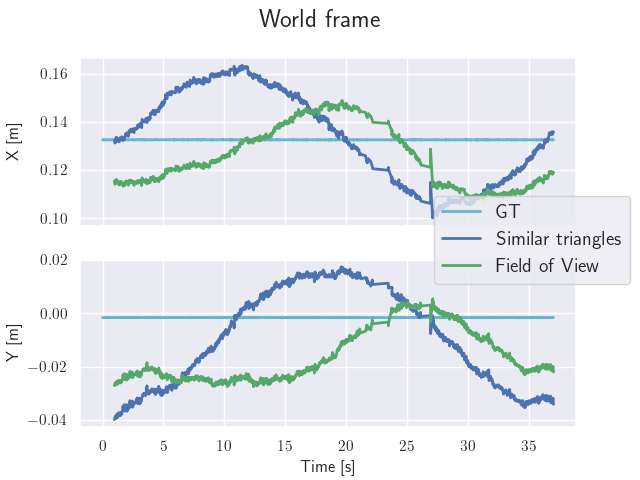

In [101]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(np_gt_track_coord[:,0], np_gt_track_coord[:,1],'-', lw=2, c='c')
axs[0].plot(np_track_coord[:,0], np_track_coord[:,1],'-', lw=2, c='b')
axs[0].plot(np_fov[:,0], np_fov[:,1],'-', lw=2, c='g')

axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_gt_track_coord[:,0], np_gt_track_coord[:,2],'-', lw=2, c='c')
axs[1].plot(np_track_coord[:,0], np_track_coord[:,2],'-', lw=2, c='b')
axs[1].plot(np_fov[:,0], np_fov[:,2],'-', lw=2, c='g')

axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)

handles, labels = axs[1].get_legend_handles_labels()
labels = ["GT", "Similar triangles", "Field of View"]
fig.legend(labels, loc='center right', ncol=1, fontsize=14)
fig.suptitle('World frame', fontsize=18, weight="bold")
fig.align_ylabels(axs)

plt.show()


if input("Save fig?") == "y":
    plt.savefig("tracks_world_frame.svg")

# Camera coordinates

In [89]:

camera_coordinates_tria = b.message_by_topic('/search/tracks/camera_coordinates_tria')
df_camera_coordinates_tria = pd.read_csv(camera_coordinates_tria)

df_camera_coordinates_tria = rename_columns(df_camera_coordinates_tria[["Time", "x", "y", "z"]], ["x_tria", "y_tria", "z_tria"])

df_camera_coordinates_tria

,Time,x_tria,y_tria,z_tria
0,1.679407e+09,1.567567,0.731085,2.443310
1,1.679407e+09,1.561914,0.728272,2.442661
2,1.679407e+09,1.555365,0.725652,2.442657
3,1.679407e+09,1.551865,0.723844,2.445395
4,1.679407e+09,1.545853,0.721476,2.446252
...,...,...,...,...
512,1.679407e+09,-1.599889,-0.830398,2.444755
513,1.679407e+09,-1.602758,-0.833148,2.445134
514,1.679407e+09,-1.606816,-0.835835,2.445326
515,1.679407e+09,-1.609359,-0.835794,2.445207


In [90]:
camera_coordinates_fov = b.message_by_topic('/search/tracks/camera_coordinates_fov')
df_camera_coordinates_fov = pd.read_csv(camera_coordinates_fov)

df_camera_coordinates_fov = rename_columns(df_camera_coordinates_fov[["Time", "x", "y", "z"]], ["x_fov", "y_fov", "z_fov"])

df_camera_coordinates_fov

,Time,x_fov,y_fov,z_fov
0,1.679407e+09,1.561741,0.731828,2.443310
1,1.679407e+09,1.554860,0.728907,2.442661
2,1.679407e+09,1.546795,0.726180,2.442657
3,1.679407e+09,1.542090,0.724268,2.445395
4,1.679407e+09,1.534600,0.721796,2.446252
...,...,...,...,...
512,1.679407e+09,-1.562664,-0.809383,2.444755
513,1.679407e+09,-1.566149,-0.812289,2.445134
514,1.679407e+09,-1.571143,-0.815136,2.445326
515,1.679407e+09,-1.574319,-0.815097,2.445207


In [91]:
# Get tracks in image coordinates

est_tracks = b.message_by_topic('/search/tracks')
df_est_tracks = pd.read_csv(est_tracks)

df_est_tracks = rename_columns(df_est_tracks[["Time", "bounding_boxes"]], ["bbs"])

df_est_tracks = ret_track_df(df_est_tracks)

df_est_tracks

,Time,id,probability,Class,center_x,center_y
0,1.679407e+09,1,0.81,human,1244.5,644.0
1,1.679407e+09,1,0.81,human,1242.5,643.0
2,1.679407e+09,1,0.81,human,1240.0,642.0
3,1.679407e+09,1,0.81,human,1238.0,641.0
4,1.679407e+09,1,0.81,human,1235.5,640.0
...,...,...,...,...,...,...
512,1.679407e+09,1,0.81,human,35.5,48.0
513,1.679407e+09,1,0.81,human,34.5,47.0
514,1.679407e+09,1,0.81,human,33.0,46.0
515,1.679407e+09,1,0.81,human,32.0,46.0


In [92]:
df_merged_track_camera_coord = sync_dfs_based_on_time([df_camera_coordinates_fov, df_camera_coordinates_tria])


np_camera_coordinates_tria = get_np_arr_without_nan(df_merged_track_camera_coord, ["x_tria", "y_tria", "z_tria"], remove_identicals=False)
np_camera_coordinates_fov = get_np_arr_without_nan(df_merged_track_camera_coord, ["x_fov", "y_fov", "z_fov"], remove_identicals=False)

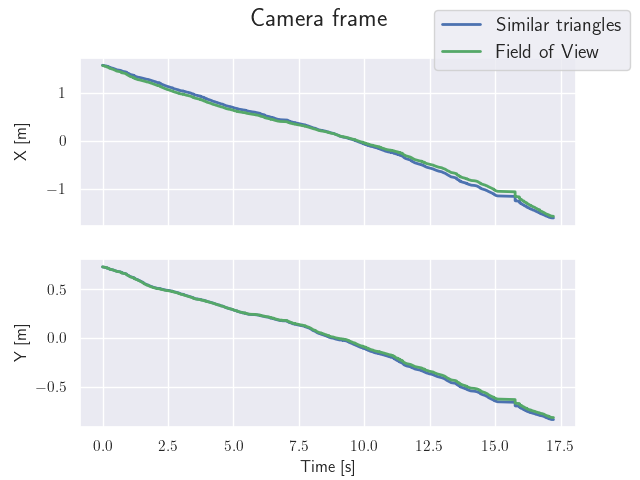

In [95]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(np_camera_coordinates_tria[:,0], np_camera_coordinates_tria[:,1],'-', lw=2, c='b')
axs[0].plot(np_camera_coordinates_fov[:,0], np_camera_coordinates_fov[:,1],'-', lw=2, c='g')

axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_camera_coordinates_tria[:,0], np_camera_coordinates_tria[:,2],'-', lw=2, c='b')
axs[1].plot(np_camera_coordinates_fov[:,0], np_camera_coordinates_fov[:,2],'-', lw=2, c='g')

axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)

handles, labels = axs[1].get_legend_handles_labels()
labels = ["Similar triangles", "Field of View"]
fig.legend(labels, loc='upper right', ncol=1, fontsize=14)
fig.suptitle('Camera frame', fontsize=18, weight="bold")
fig.align_ylabels(axs)

plt.show()


if input("Save fig?") == "y":
    plt.savefig("tracks_camera_frame.svg")


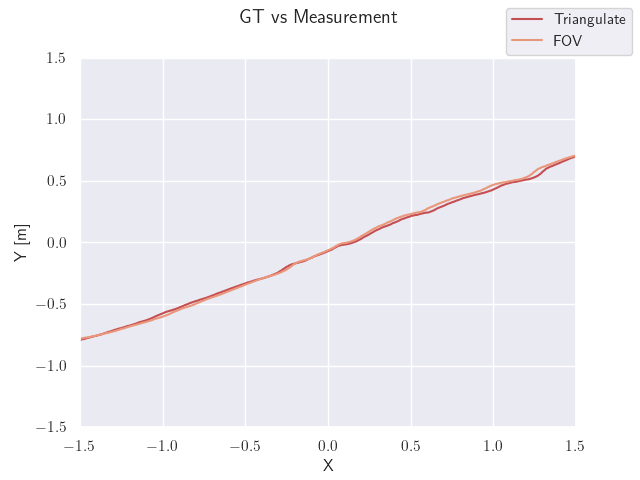

In [70]:
fig = plt.figure()

plt.plot(np_camera_coordinates_tria[:,1], np_camera_coordinates_tria[:,2],'-', ms=1, c='r')
plt.plot(np_camera_coordinates_fov[:,1], np_camera_coordinates_fov[:,2],'-', ms=1, c='darksalmon')

plt.xlabel("X")
plt.ylabel('Y [m]')
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
labels = ["Triangulate", "FOV"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('GT vs Measurement', fontsize=14)
fig.align_ylabels(axs)